In [1]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer
# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm

# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots

RANDOM = 0
figure_path = "../figures/NCDB_8_features_N924/"

## 1. Prep data

- load data 

In [2]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_N924.csv") 
df.shape

(924, 9)

In [5]:

# fix up some features
df['AGE'] = df.AGE.astype('float')
df['tumor_site'] = df.tumor_site.astype("category")

outcome = df['metastasis']
features = df.drop(columns =['metastasis'])
features.shape
features['SEX']  = features.SEX.replace({0:2, 1:1})

### define preprrocessing
- one-hot encode categorical features
- standard scale (zscore) continuous features

In [6]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_depth', 'tumor_size']
cat_features = ['tumor_site']

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first'))])


# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)],
    remainder = 'passthrough')

# Generate the preprocessor
preprocessed_X = preprocessor.fit_transform(features)
check_preproc = pd.DataFrame(preprocessed_X)
check_preproc.shape


(924, 10)

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 5 folds repeated 5x with random sampling

In [14]:
# split into train-test split, 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
# make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats =  5,  
                                    random_state = 0)

## Model: regularized logistic regression
- automated feature selection via L1 regularization  (Lasso)

In [15]:
Lasso_L1 = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                             penalty = 'l1', 
                              solver = 'saga', 
                             random_state = RANDOM)
Lasso_pipe = Pipeline(steps = [('preproc', preprocessor),
                              # ('interactions', add_interactions),
                              ('model', Lasso_L1)])

Lasso_pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'tumor_depth',
                                                   'tumor_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['tumor_site'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty='l1', random_state=0,
                                    solver='saga'))])

## Tune the model 
- grid search with different levels of regularization (parameter C, inverse of alpha in R)
- smaller values of C = larger values of alpha = more regularization
- applied to cross-validation folds 
- get several metrics out! 


In [16]:

score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
              'f1': 'f1',
              'roc_auc': 'roc_auc', 
              'average_precision': 'average_precision', 
             'brier_score_loss': 'brier_score_loss'}

In [17]:
# define hyper-parametrs to tune 
# C is the inverse of alpha 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100] }
# define the grid search parameters 
Lasso_grid = GridSearchCV(Lasso_pipe,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "recall",
                    n_jobs =  -1)
# fit hte model 
Lasso_grid.fit(X_trainval, y_trainval)
# get the results and store them!
grid_results = pd.DataFrame(Lasso_grid.cv_results_)
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log(x))


In [18]:
# clean up dataframe so only have mean scores 
grid_results = grid_results[['param_model__C', 'log_C',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_average_precision', 'mean_test_average_precision',
                             'mean_train_brier_score_loss', 'mean_test_brier_score_loss']]


In [19]:
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['param_model__C', 'log_C'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc',
                                         'mean_train_average_precision', 'mean_test_average_precision',
                                          'mean_train_brier_score_loss', 'mean_test_brier_score_loss'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")


## Visualize hyperparameter tuning: learning curves
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 

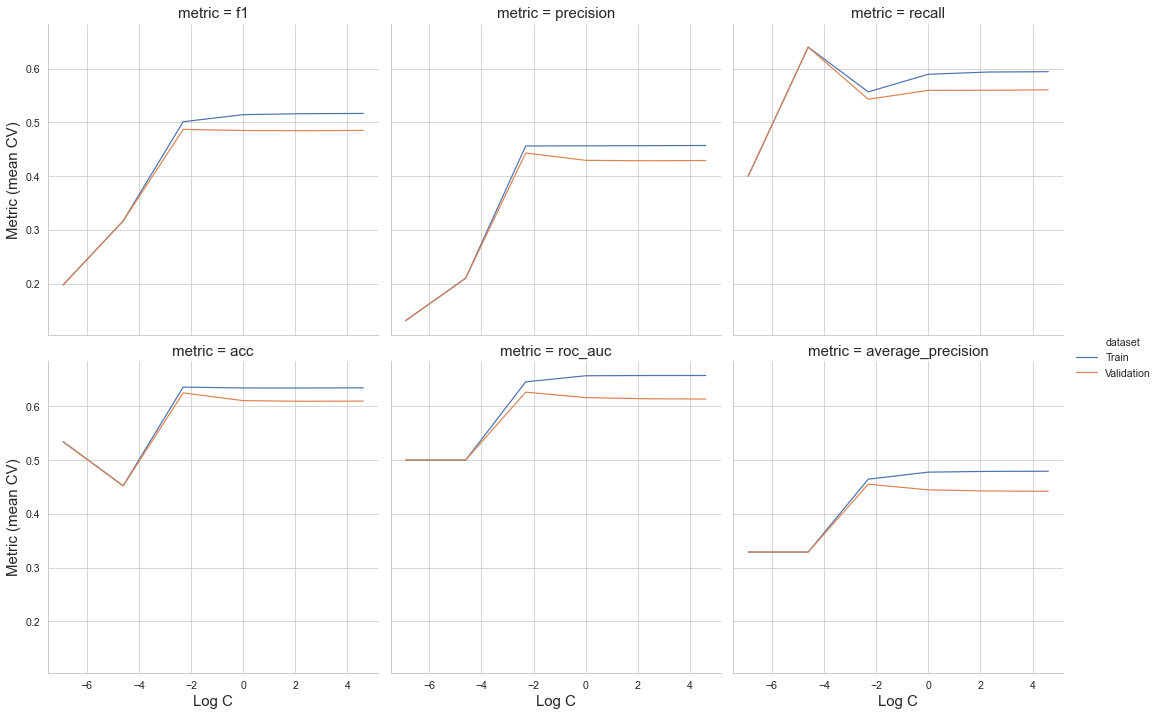

In [20]:
# figure of model comparisons on training  
g = sns.relplot(data = grid_results_long[grid_results_long.metric != "brier_score_loss"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset",  
                kind = "line", col = "metric", col_wrap = 3)
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Metric (mean CV)", size = 15)
g.set_titles(size = 15)
plt.savefig(os.path.join(figure_path, "Grid_CV_learning_curves.png"))



## Find the best model

In [374]:
best_metric = grid_results['mean_test_average_precision'].max()
best_model = pd.DataFrame(grid_results[grid_results['mean_test_average_precision']== best_metric])

print("Best PR AUC {}".format(best_metric.round(2)))
print("Best C parameter: {}".format(best_model['param_model__C']))


Best PR AUC 0.5
Best C parameter: 5    100.0
Name: param_model__C, dtype: float64


## Validate model on hold-out test set
### define & fit the model 
- using entire train-validation set.
- need to pre-process the data first!

In [375]:
# define and fit the model 
best_LR_model = LogisticRegression(class_weight = "balanced",
                                   max_iter = 1000,
                                   penalty = 'l1', 
                                   solver = 'saga',
                                   C = 0.01)

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preprocessor.fit_transform(X_trainval)
preproc_X_test = preprocessor.fit_transform(X_test)

# fit the model to the entire train-validation set
best_LR_model.fit(preproc_X_trainval, y_trainval)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='saga')

### get model scores on test set

In [376]:
y_pred = best_LR_model.predict(preproc_X_test)
# get scores 
best_test_scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                                "accuracy", "f1 score", "pr_auc"],
                            "scores" : [precision_score(y_test, y_pred), 
                                       recall_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                       f1_score(y_test, y_pred), 
                                       average_precision_score(y_test, y_pred)]
                           })
best_test_scores['scores'] = best_test_scores.scores.round(3)

print("Best Model scores on hold-out test set")
display(best_test_scores)# define and fit the model 


Best Model scores on hold-out test set


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metrics,scores
0,precision,0.000
1,recall,0.000
2,roc_auc,0.500
3,accuracy,0.714
4,f1 score,0.000
5,pr_auc,0.286


### get model predictions from the test set

../mcc_metastasis/modeling.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../mcc_metastasis/modeling.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


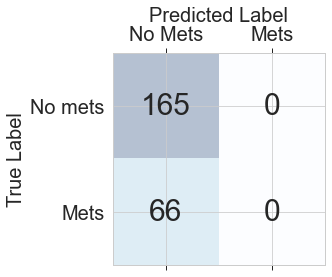

True negatives identified: Proportion of sample correctly identified  as low risk, no biopsy necessary: 0.71
True positives identified: Proportion of sample correctly classified as high risk, need biopsy: 0.0
Recall / Sensitivity: 
 Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.0
False negative rate: 
 Patients mis-classified as low risk, but need biopsy: 1.0

 Specificity/True negative rate: 
 Of people who are actually low risk, how many are classified as low risk? 1.0
False positive rate: 
 Patients classifiedas high risk, but don't need biopsy: 0.0
Precision / Positive Predictive Value: 
 Of all people recommended for biopsy, how many actually have metastasis? nan
Negative Predictive Value: 
 Of people classified as low risk,  how many are actually low risk? 1


../mcc_metastasis/modeling.py:109: RuntimeWarning: invalid value encountered in long_scalars
  precision = round(true_positives / (false_positives + true_positives),2)


In [373]:
cm = confusion_matrix(y_test, y_pred)
modeling.pretty_cm(cm, filename = os.path.join(figure_path, "best_LR_confusion_matrix_0.5.png"))
modeling.get_cm_info(cm, y_test) 

## Tuning the decision boundary 
- predicted probabilty > 0.4

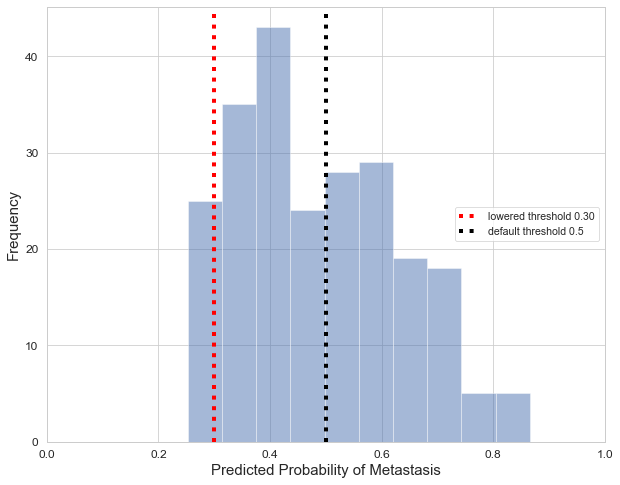

<Figure size 432x288 with 0 Axes>

In [358]:
# get predictions on hold-out test set.
key_thresh = 0.3
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
custom_plots.plot_predprobs(y_pred_prob, key_thresh ,
                           filename = os.path.join(figure_path, "best_LR_model_predprobs.png"))


../mcc_metastasis/modeling.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../mcc_metastasis/modeling.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


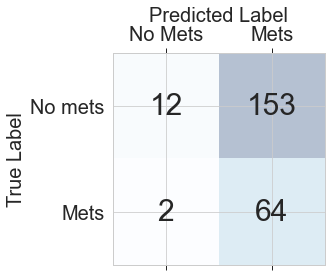

True negatives identified: Proportion of sample correctly identified  as low risk, no biopsy necessary: 0.05
True positives identified: Proportion of sample correctly classified as high risk, need biopsy: 0.28
Recall / Sensitivity: 
 Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.97
False negative rate: 
 Patients mis-classified as low risk, but need biopsy: 0.03

 Specificity/True negative rate: 
 Of people who are actually low risk, how many are classified as low risk? 0.07
False positive rate: 
 Patients classifiedas high risk, but don't need biopsy: 0.93
Precision / Positive Predictive Value: 
 Of all people recommended for biopsy, how many actually have metastasis? 0.29
Negative Predictive Value: 
 Of people classified as low risk,  how many are actually low risk? 1


In [359]:
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
y_pred_adjusted  = y_pred_prob > key_thresh
cm = confusion_matrix(y_test, y_pred_adjusted)
modeling.pretty_cm(cm, filename = os.path.join(figure_path, "best_LR_confusion_matrix_adjusted.png"))
modeling.get_cm_info(cm, y_test)

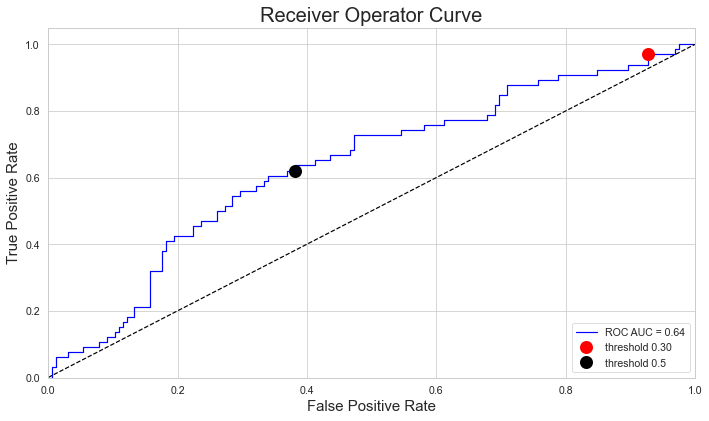

In [360]:
    
custom_plots.plot_roc_curve(y_test, y_pred_prob, key_thresh,
         filename = os.path.join(figure_path, "best_LR_PR_curve.png"))

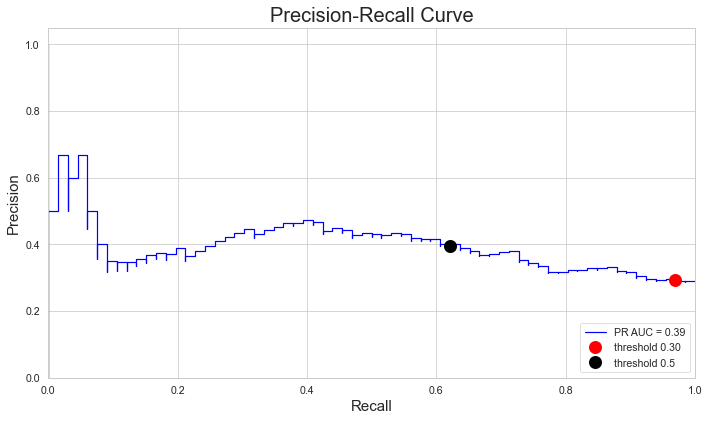

In [361]:

custom_plots.plot_pr_curve(y_test, y_pred_prob, key_thresh,
         filename = os.path.join(figure_path, "best_LR_PR_curve.png"))

## Calibrate prbabilities
- isotonic calibration is non-parametric, signmoid is parametric
- sigmoid works better.
- marginal improvement to brier score

Lasso Regression:
	Brier: 0.238
	Precision: 0.398
	Recall: 0.621
	F1: 0.485

Lasso Regression + Isotonic:
	Brier: 0.198
	Precision: 0.278
	Recall: 0.076
	F1: 0.119



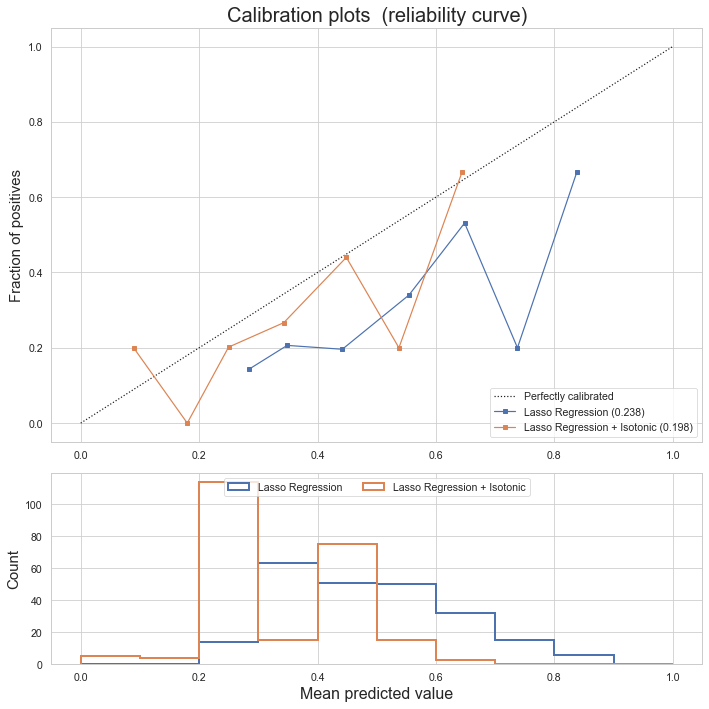

In [362]:

platts_scaling = CalibratedClassifierCV(best_LR_model, cv=2, method='isotonic')
platts_scaling.fit(preproc_X_trainval, y_trainval)
calibrated_probs = platts_scaling.predict_proba(preproc_X_test)[:,1]
custom_plots.plot_calibration_curve(best_LR_model, "Lasso Regression", 1,
                       preproc_X_trainval, preproc_X_test, y_trainval, y_test,
                      filename = os.path.join(figure_path, "best_LR_calibration_plot.png"))

### Re-tune the decision boundary with calibrated probabilitiies
- 0.2 instead of 0.4
- so effectively, best we can get is identifying patients with < 20% risk

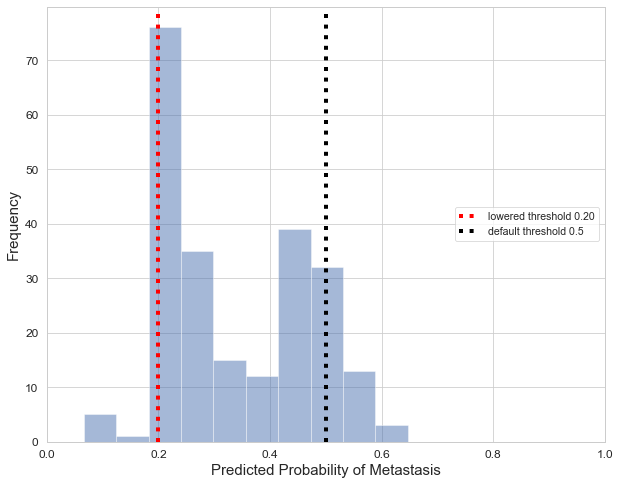

<Figure size 432x288 with 0 Axes>

In [363]:

key_thresh = 0.20
custom_plots.plot_predprobs(calibrated_probs, key_thresh, 
                            filename = os.path.join(figure_path, "best_LR_predprobs_calibrated.png"))

../mcc_metastasis/modeling.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['No Mets', 'Mets'])
../mcc_metastasis/modeling.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No mets', 'Mets'])


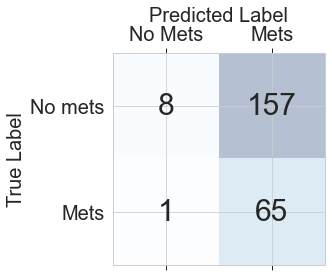

True negatives identified: Proportion of sample correctly identified  as low risk, no biopsy necessary: 0.03
True positives identified: Proportion of sample correctly classified as high risk, need biopsy: 0.28
Recall / Sensitivity: 
 Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.98
False negative rate: 
 Patients mis-classified as low risk, but need biopsy: 0.02

 Specificity/True negative rate: 
 Of people who are actually low risk, how many are classified as low risk? 0.05
False positive rate: 
 Patients classifiedas high risk, but don't need biopsy: 0.95
Precision / Positive Predictive Value: 
 Of all people recommended for biopsy, how many actually have metastasis? 0.29
Negative Predictive Value: 
 Of people classified as low risk,  how many are actually low risk? 1


In [364]:
y_pred_calibrated = calibrated_probs > key_thresh
cm = confusion_matrix(y_test, y_pred_calibrated)
modeling.pretty_cm(cm, os.path.join(figure_path, "best_LR_confusion_matrix_calibrated_adjusted.png"))
modeling.get_cm_info(cm, y_test)

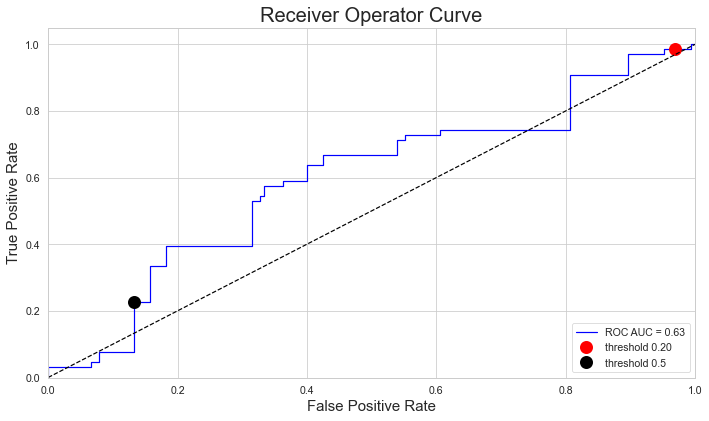

In [365]:
custom_plots.plot_roc_curve(y_test, calibrated_probs, key_thresh,
                           filename =  os.path.join(figure_path, "best_LR_calibrated_ROC_curve.png"))

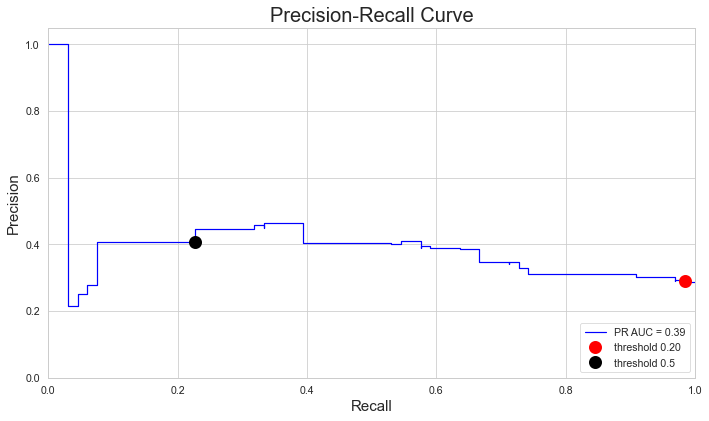

In [366]:
custom_plots.plot_pr_curve(y_test, calibrated_probs, key_thresh,
                          filename =  os.path.join(figure_path, "best_LR_calibrated_PR_curve.png"))

## get feature importance / coefficients
### ... first, get feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.

In [367]:
preproc_X_test_df = pd.DataFrame(preproc_X_test)
# apply the function to  get the featture names, because preprocessor mixes up order.
preproc_feature_names = modeling.get_feature_names(preprocessor)
# check output!! 
preproc_feature_names


../mcc_metastasis/modeling.py:159: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  % (str(name), type(trans).__name__))


['num__AGE',
 'num__tumor_depth',
 'num__tumor_size',
 'onehot__x0_head_neck',
 'onehot__x0_other',
 'onehot__x0_trunk',
 'SEX',
 'immuno_suppressed',
 'tumor_lymphocytes',
 'lymph_vasc_invasion']

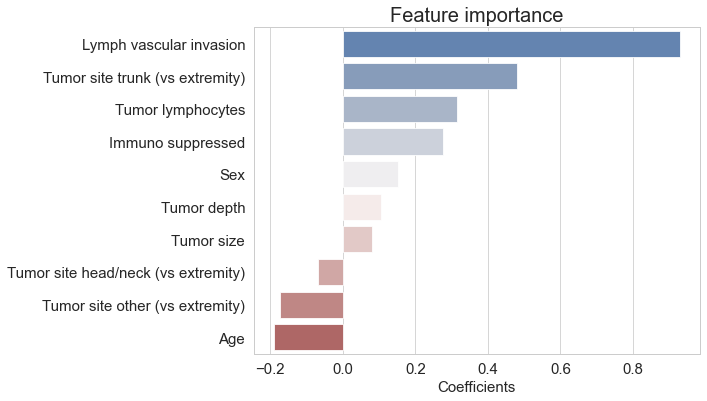

In [368]:
prettier_names = ['Age', 'Tumor depth', 'Tumor size',
                 'Tumor site head/neck (vs extremity)',
                 'Tumor site other (vs extremity)', 'Tumor site trunk (vs extremity)',
                   'Sex',
                  'Immuno suppressed', 'Tumor lymphocytes', 'Lymph vascular invasion']
preproc_X_test_df.columns = prettier_names
# apply custom function to get coefficients from model 
coefs_df = modeling.get_ordered_coefs(best_LR_model, preproc_X_test_df)
custom_plots.plot_coefs(coefs_df, filename = os.path.join(figure_path, "best_LR_feature_weights.png"))

## Confirm findings with statsmodels 
### fit Lasso model on trainval set 
- they don't match perfectly because i am balancing class weights in sklearn!
- if i remove that, they are near identical.


In [278]:
# set up X and y as arrays 
# need to explicitly add constant (intercept) to X data 
preproc_X_trainval_int = sm.add_constant(preproc_X_trainval)
y_trainval_array  = np.asarray(y_trainval)

In [369]:
# re-creating best model 
# C = 0.1, so alpha is inverse, should be 10 
# C = 100, alpha = 1 / 100 = 0.01
log_reg = sm.Logit(y_trainval_array, preproc_X_trainval_int)
lasso_model = log_reg.fit_regularized(method = 'l1', alpha = 0.01)
print(lasso_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6011066995056816
            Iterations: 155
            Function evaluations: 155
            Gradient evaluations: 155
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  693
Model:                          Logit   Df Residuals:                      682
Method:                           MLE   Df Model:                           10
Date:                Sat, 10 Oct 2020   Pseudo R-squ.:                 0.05117
Time:                        19:15:15   Log-Likelihood:                -416.53
converged:                       True   LL-Null:                       -439.00
Covariance Type:            nonrobust   LLR p-value:                 2.243e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 11 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [370]:
sklearn_coef = pd.DataFrame( best_LR_model.coef_.T, columns = ["sklearn"])
statmod_coef = pd.DataFrame(lasso_model.params[1:11], columns = ["statmod"])
features = pd.DataFrame(preproc_X_test_df.columns, columns = ["features"])
coefs_compare = pd.concat([features, sklearn_coef, statmod_coef],  axis = 1)
# close, but not exacctly.
coefs_compare

,features,sklearn,statmod
0,Age,-0.190714,-0.146072
1,Tumor depth,0.104524,0.128431
2,Tumor size,0.079654,-0.004566
3,Tumor site head/neck (vs extremity),-0.067539,-0.015903
4,Tumor site other (vs extremity),-0.173967,-0.094681
5,Tumor site trunk (vs extremity),0.480836,0.385493
6,Sex,0.151527,0.005339
7,Immuno suppressed,0.275728,0.285667
8,Tumor lymphocytes,0.315738,0.264481
9,Lymph vascular invasion,0.928976,0.842208


In [123]:
selected_features = coefs_compare.features[abs(coefs_compare.sklearn) > 0.05]
selected_features


0                        Age
8    Lymph vascular invasion
Name: features, dtype: object

### sanity check, run regular logiistic regression in stats models
- they are identical as longg as you remove class_weights = "balanced"
- and use solver = lbfgs (instead of saga)

In [124]:
# define and fit the model 
regular_LR_model = LogisticRegression(max_iter = 1000,
                                   penalty = 'none', solver = 'lbfgs')

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preprocessor.fit_transform(X_trainval)
# fit the model to the entire train-validation set
regular_LR_model.fit(preproc_X_trainval, y_trainval)

# confirming that sklearn adds an intercept! 
regular_LR_model.intercept_

array([-1.10832884])

In [125]:
log_reg = sm.Logit(y_trainval_array, preproc_X_trainval_int)
log_model = log_reg.fit()
print(log_model.summary())



Optimization terminated successfully.
         Current function value: 0.601594
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  691
Model:                          Logit   Df Residuals:                      681
Method:                           MLE   Df Model:                            9
Date:                Fri, 09 Oct 2020   Pseudo R-squ.:                 0.06301
Time:                        16:55:04   Log-Likelihood:                -415.70
converged:                       True   LL-Null:                       -443.65
Covariance Type:            nonrobust   LLR p-value:                 8.175e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1083      0.188     -5.903      0.000      -1.476      -0.740
x1            -0.2072      0.

In [126]:
sklearn_coef = pd.DataFrame(regular_LR_model.coef_.T, columns = ["sklearn"])
statmod_coef = pd.DataFrame(log_model.params[1:11], columns = ["statmod"])
features = pd.DataFrame(preproc_X_test_df.columns, columns = ["features"])
coefs_compare = pd.concat([features, sklearn_coef, statmod_coef],  axis = 1)

coefs_compare

,features,sklearn,statmod
0,Age,-0.207152,-0.207168
1,Tumor size (cm),0.089214,0.089212
2,Tumor site head/neck (vs extremity),-0.031362,-0.031337
3,Tumor site other (vs extremity),-0.151502,-0.151513
4,Tumor site trunk (vs extremity),0.556381,0.556424
5,Sex,-0.180049,-0.180049
6,Immuno suppressed,0.261345,0.261325
7,Tumor lymphocytes,0.330917,0.330907
8,Lymph vascular invasion,0.937038,0.937042
